In [1]:
import torch
import torch.nn as nn
import numpy as np
import time
import os
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
from scipy.stats import binned_statistic

from models import CFM
from models import Classifier
from gaussian_toy import GaussianToy
from plots import plot_naive_unfold, plot_reweighted_distribution, plot_prior_unfold, SetStyle
SetStyle()

In [2]:
import logging
import sys
for h in logging.root.handlers[:]:
    logging.root.removeHandler(h)
logging.basicConfig(
    level=logging.INFO,
    stream=sys.stdout,
    format="%(asctime)s %(levelname)s %(message)s",
)

# Create Gaussian toy example. Define six datasets:
1. Reco-level simulation
2. Gen-level simulation
3. Background simulation
4. Reco-level data
5. Gen-level data
6. Background data

In [3]:
device = 'cuda'
data_params = { "n_dim": 1,
                "n_mc": 1_000_000,
                "mc_mu": 0,
                "mc_sigma": 1,
                "n_data": 1_000_000,
                "data_mu": 0.2,
                "data_sigma": 0.8,
                "detector_mu": 0,
                "detector_sigma": 0.5,
                "n_background": 100_000,
                "background_mu": 0,
                "background_sigma": 1.2,
                "mc_rec_cut": True,
                "mc_gen_cut": True,
                "data_rec_cut": True,
                "data_gen_cut": True ,
                "efficiency": 0.1,
                "acceptance": 0.1,
                "empty_value": -5.0,
}

In [4]:
ToyModel = GaussianToy(data_params)

# Define background subtraction CFM

In [5]:
bkg_mc = ToyModel.mc_background_rec
data_rec = ToyModel.data_rec

In [6]:
generator_params = {"hidden_layers": 4,
                   "internal_size": 64,
                   "lr": 1.e-5,
                   "n_epochs" : 100,
                   "batch_size" : 128,
                   "batch_size_sample": 2000}

In [7]:
signal_generator = CFM(data_params['n_dim'], 0, generator_params)

In [8]:
weights = torch.cat([torch.ones_like(data_rec[ToyModel.data_rec_mask.bool(),0]),
                     -torch.ones_like(bkg_mc[:,0])])
data = torch.cat([data_rec[ToyModel.data_rec_mask.bool()], bkg_mc], 0)
signal_generator.train(data, weights=weights)

2025-05-28 10:48:30,412 INFO Training CFM for 100 epochs with lr 1e-05
2025-05-28 10:48:49,869 INFO Epoch 1: train_loss=1.3783, test_loss=1.2151
2025-05-28 10:49:07,623 INFO Epoch 2: train_loss=1.2173, test_loss=1.2199
2025-05-28 10:49:25,341 INFO Epoch 3: train_loss=1.2133, test_loss=1.2171
2025-05-28 10:49:43,074 INFO Epoch 4: train_loss=1.2137, test_loss=1.2076
2025-05-28 10:50:01,001 INFO Epoch 5: train_loss=1.2113, test_loss=1.2068
2025-05-28 10:50:18,696 INFO Epoch 6: train_loss=1.2086, test_loss=1.2095
2025-05-28 10:50:38,400 INFO Epoch 7: train_loss=1.2096, test_loss=1.2087
2025-05-28 10:50:58,109 INFO Epoch 8: train_loss=1.2090, test_loss=1.2055
2025-05-28 10:51:17,729 INFO Epoch 9: train_loss=1.2095, test_loss=1.2064
2025-05-28 10:51:35,454 INFO Epoch 10: train_loss=1.2120, test_loss=1.2051
2025-05-28 10:51:53,160 INFO Epoch 11: train_loss=1.2078, test_loss=1.2075
2025-05-28 10:52:10,862 INFO Epoch 12: train_loss=1.2092, test_loss=1.2069
2025-05-28 10:52:28,687 INFO Epoch 13:

# Generate the signal and generate empty events at reco level

In [9]:
num_data_reco = ToyModel.data_signal_rec[:,0][ToyModel.data_rec_mask[:data_params["n_data"]].bool()].size(0)
generated_signal = signal_generator.evaluate(num_evts = num_data_reco,device = device) #N*(1-delta)

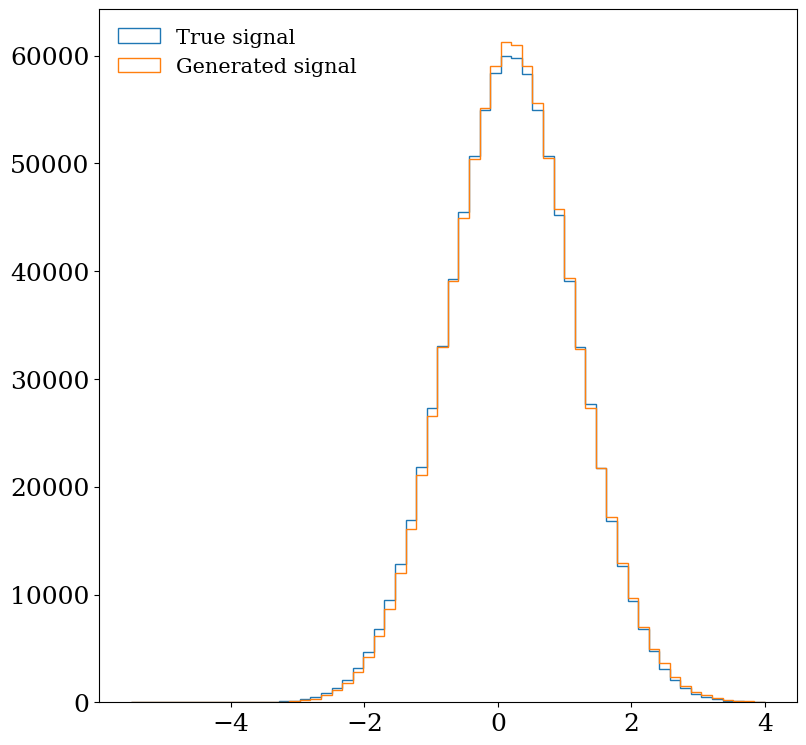

In [10]:
y_true = plt.hist(ToyModel.data_signal_rec[:,0][ToyModel.data_rec_mask[:data_params["n_data"]].bool()].cpu().detach().numpy(),bins = 60, range = [-5.5,4],label = "True signal", histtype='step')
y_gen = plt.hist(generated_signal[:,0].cpu().detach().numpy(),bins = 60, range = [-5.5,4],label = "Generated signal", histtype='step')
plt.legend()

In [11]:
num_data_empty = num_data_reco*data_params['acceptance']/(1.0 - data_params['acceptance']) #N*(1-delta)*epsilon/(1-epsilon)
#Add the empty events to the generated signals
generated_signal = torch.cat([generated_signal,data_params["empty_value"]*torch.ones_like(generated_signal[:int(num_data_empty)])])
signal_mask = generated_signal[:,0] != data_params["empty_value"]

In [12]:
print(f"Number of expected signal events in the data {generated_signal.size(0)}")

Number of expected signal events in the data 999645


# Train Acceptance classifier

In [13]:
acceptance_true = ToyModel.mc_rec[(ToyModel.mc_rec_mask.bool()) & (ToyModel.mc_gen_mask.bool())]
acceptance_false = ToyModel.mc_rec[(ToyModel.mc_rec_mask.bool()) & ~(ToyModel.mc_gen_mask.bool())]

In [14]:
acceptance_classifier_params = { "hidden_layers": 4,
                                 "internal_size": 64,
                                 "lr": 3.e-5,
                                 "n_epochs" : 30,
                                 "batch_size" : 128,
                                 "batch_size_sample": 2000
}

In [15]:
acceptance_classifier = Classifier(dims_in=1, params=acceptance_classifier_params,model_name="acceptance classifier")

In [16]:
acceptance_classifier.train_classifier(acceptance_true, acceptance_false, balanced=False)

2025-05-28 10:59:39,586 INFO     Training with unbalanced training set with weight 9.014072129396846
2025-05-28 10:59:39,587 INFO Training classifier for 270 epochs with lr 3e-05
2025-05-28 10:59:42,380 INFO     Finished epoch 0 with average loss 6.908952713012695 after time 2.8
2025-05-28 11:02:13,226 INFO     Finished epoch 54 with average loss 3.2523157596588135 after time 153.6
2025-05-28 11:04:48,169 INFO     Finished epoch 108 with average loss 3.2523021697998047 after time 308.6
2025-05-28 11:07:19,797 INFO     Finished epoch 162 with average loss 3.2522459030151367 after time 460.2
2025-05-28 11:09:51,621 INFO     Finished epoch 216 with average loss 3.252152442932129 after time 612.0
2025-05-28 11:12:24,976 INFO     Finished epoch 269 with average loss 3.25223970413208 after time 765.4


# Train efficiency classifier

In [17]:
efficiency_classifier_params = { "hidden_layers": 4,
                                 "internal_size": 64,
                                 "lr": 1.e-4,
                                 "n_epochs" : 30,
                                 "batch_size" : 128,
                                 "batch_size_sample": 2000
}

In [18]:
efficiency_true = ToyModel.mc_gen[(ToyModel.mc_rec_mask.bool()) & (ToyModel.mc_gen_mask.bool())]
efficiency_false = ToyModel.mc_gen[~(ToyModel.mc_rec_mask.bool()) & (ToyModel.mc_gen_mask.bool())]

In [19]:
efficiency_classifier = Classifier(dims_in = 1, params = efficiency_classifier_params,model_name="efficiency classifier")

In [20]:
efficiency_classifier.train_classifier(efficiency_true, efficiency_false, balanced=False)

2025-05-28 11:12:25,079 INFO     Training with unbalanced training set with weight 9.0269255620168
2025-05-28 11:12:25,080 INFO Training classifier for 270 epochs with lr 0.0001
2025-05-28 11:12:27,876 INFO     Finished epoch 0 with average loss 6.580810546875 after time 2.8
2025-05-28 11:14:57,990 INFO     Finished epoch 54 with average loss 3.2536418437957764 after time 152.9
2025-05-28 11:17:28,655 INFO     Finished epoch 108 with average loss 3.2535557746887207 after time 303.6
2025-05-28 11:20:00,898 INFO     Finished epoch 162 with average loss 3.254213333129883 after time 455.8
2025-05-28 11:22:33,534 INFO     Finished epoch 216 with average loss 3.2535629272460938 after time 608.5
2025-05-28 11:25:02,653 INFO     Finished epoch 269 with average loss 3.2535459995269775 after time 757.6


# Let's train the detector response flow p(reco|gen) and the initial p(gen) flows

In [21]:
gen_generator = CFM(dims_x = data_params['n_dim'], dims_c = 0,params = generator_params)

In [22]:
gen_generator.train(ToyModel.mc_gen[ToyModel.mc_gen_mask.bool()],weights = torch.ones_like(ToyModel.mc_gen[ToyModel.mc_gen_mask.bool()][:,0]))

2025-05-28 11:25:02,722 INFO Training CFM for 100 epochs with lr 1e-05
2025-05-28 11:25:17,400 INFO Epoch 1: train_loss=1.7913, test_loss=1.5783
2025-05-28 11:25:32,127 INFO Epoch 2: train_loss=1.5795, test_loss=1.5754
2025-05-28 11:25:46,804 INFO Epoch 3: train_loss=1.5828, test_loss=1.5795
2025-05-28 11:26:01,486 INFO Epoch 4: train_loss=1.5758, test_loss=1.5747
2025-05-28 11:26:16,178 INFO Epoch 5: train_loss=1.5753, test_loss=1.5731
2025-05-28 11:26:30,804 INFO Epoch 6: train_loss=1.5730, test_loss=1.5813
2025-05-28 11:26:45,404 INFO Epoch 7: train_loss=1.5727, test_loss=1.5734
2025-05-28 11:27:00,071 INFO Epoch 8: train_loss=1.5692, test_loss=1.5611
2025-05-28 11:27:14,744 INFO Epoch 9: train_loss=1.5733, test_loss=1.5822
2025-05-28 11:27:29,442 INFO Epoch 10: train_loss=1.5749, test_loss=1.5698
2025-05-28 11:27:44,166 INFO Epoch 11: train_loss=1.5756, test_loss=1.5680
2025-05-28 11:27:58,853 INFO Epoch 12: train_loss=1.5739, test_loss=1.5724
2025-05-28 11:28:13,565 INFO Epoch 13:

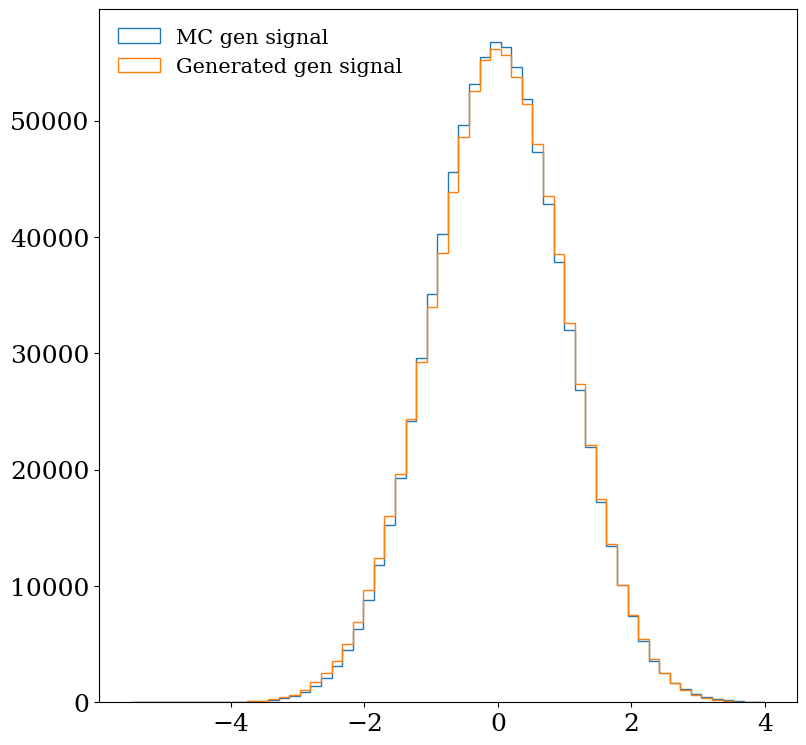

In [23]:
y_true = plt.hist(ToyModel.mc_gen[:,0][ToyModel.mc_gen_mask.bool()].cpu().detach().numpy(),
                  bins = 60, range = [-5.5,4],label = "MC gen signal", histtype='step')
y_gen = plt.hist(gen_generator.evaluate(num_evts = ToyModel.mc_gen[ToyModel.mc_gen_mask.bool()].size(0),device=device).cpu().detach().numpy(),
                 bins = 60, range = [-5.5,4],label = "Generated gen signal", histtype='step')
plt.legend()

In [24]:
detector_generator = CFM(dims_x = data_params['n_dim'], dims_c = data_params['n_dim'],params = generator_params)

In [25]:
detector_generator.train(ToyModel.mc_rec[ToyModel.mc_rec_mask.bool()],
                         weights = torch.ones_like(ToyModel.mc_rec[ToyModel.mc_rec_mask.bool()][:,0]), 
                         data_c = ToyModel.mc_gen[ToyModel.mc_rec_mask.bool()])

using conditional model
2025-05-28 11:32:16,040 INFO Training CFM for 100 epochs with lr 1e-05
2025-05-28 11:32:32,411 INFO Epoch 1: train_loss=1.4277, test_loss=0.8853
2025-05-28 11:32:48,699 INFO Epoch 2: train_loss=0.8544, test_loss=0.8450
2025-05-28 11:33:04,958 INFO Epoch 3: train_loss=0.8440, test_loss=0.8464
2025-05-28 11:33:21,206 INFO Epoch 4: train_loss=0.8382, test_loss=0.8370
2025-05-28 11:33:37,534 INFO Epoch 5: train_loss=0.8296, test_loss=0.8220
2025-05-28 11:33:53,984 INFO Epoch 6: train_loss=0.8104, test_loss=0.7993
2025-05-28 11:34:10,427 INFO Epoch 7: train_loss=0.7976, test_loss=0.7942
2025-05-28 11:34:26,923 INFO Epoch 8: train_loss=0.7948, test_loss=0.7898
2025-05-28 11:34:43,323 INFO Epoch 9: train_loss=0.7903, test_loss=0.7917
2025-05-28 11:34:59,758 INFO Epoch 10: train_loss=0.7913, test_loss=0.7882
2025-05-28 11:35:16,200 INFO Epoch 11: train_loss=0.7893, test_loss=0.7878
2025-05-28 11:35:32,744 INFO Epoch 12: train_loss=0.7905, test_loss=0.7897
2025-05-28 11:

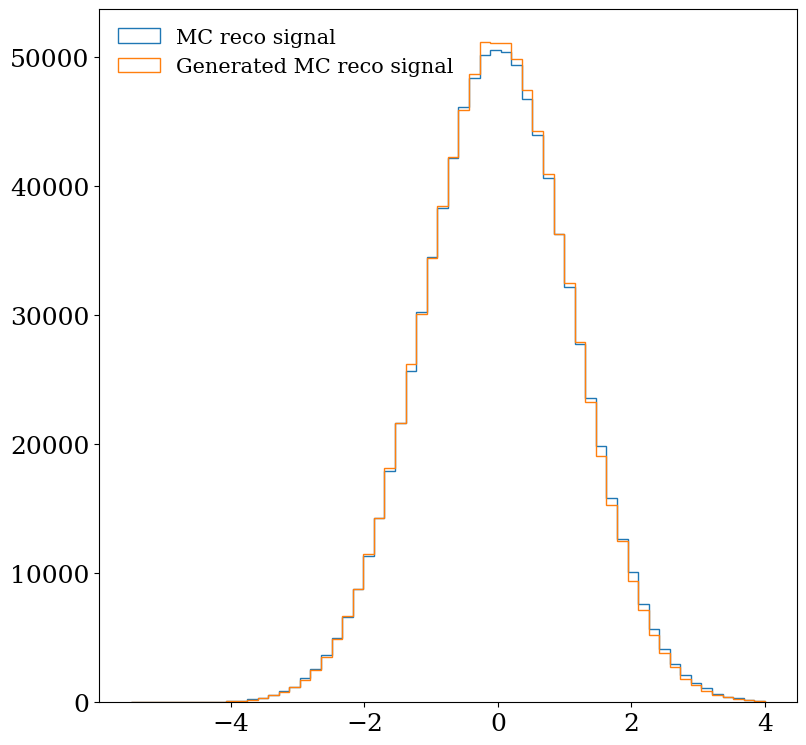

In [26]:
y_true = plt.hist(ToyModel.mc_rec[:,0][ToyModel.mc_rec_mask.bool()].cpu().detach().numpy(),
                  bins = 60, range = [-5.5,4],label = "MC reco signal", histtype='step')
y_gen = plt.hist(detector_generator.evaluate(data_c = ToyModel.mc_gen[ToyModel.mc_rec_mask.bool()]).cpu().detach().numpy(),
                 bins = 60, range = [-5.5,4],label = "Generated MC reco signal", histtype='step')
plt.legend()

# Start the unfolding!

In [27]:
def sample_reco(nevts,empty_fraction, efficiency_classifier,detector_model,gen_model):
    ''' Generates h(reco|gen) samples by sampling from: h(reco|gen) = c(gen) + (1-c(gen))*p(reco|gen)*p(gen) '''
    gen_events = gen_model.evaluate(num_evts = nevts,device=device)
    gen_mask = ToyModel.apply_efficiency_acceptance_effects(gen_events,empty_fraction)
    #By definition generated events are within acceptance
    gen_events = gen_events[gen_mask.bool()] 
    efficiency = efficiency_classifier.evaluate(gen_events, return_weights=False)
    sample_efficiency = torch.bernoulli(efficiency)


    num_data_empty = nevts*data_params['efficiency']/(1.0 - data_params['efficiency']) #N*(1-delta)*epsilon/(1-epsilon)
    gen_events = torch.cat([gen_events,
                            data_params["empty_value"] * torch.ones_like(gen_events[: int(num_data_empty)])])
    gen_mask = gen_events[:,0] != data_params["empty_value"] 
    
    #By definition, events not passing gen should pass reco
    sample_efficiency = torch.cat(
        [sample_efficiency,
         torch.ones_like(sample_efficiency[:int(num_data_empty)])]
        )
    
    reco_events = detector_model.evaluate(data_c=gen_events)
    reco_events[~sample_efficiency.bool()] = data_params["empty_value"]*torch.ones_like(gen_events[~sample_efficiency.bool()])
    return  reco_events, gen_events, gen_mask, sample_efficiency

Running iteration 0
using conditional model
2025-05-28 11:47:22,344 INFO Training CFM for 100 epochs with lr 1e-05
2025-05-28 11:47:40,444 INFO Epoch 1: train_loss=1.4623, test_loss=0.9691
2025-05-28 11:47:58,604 INFO Epoch 2: train_loss=0.9100, test_loss=0.8858
2025-05-28 11:48:14,863 INFO Epoch 3: train_loss=0.8783, test_loss=0.8712
2025-05-28 11:48:31,067 INFO Epoch 4: train_loss=0.8689, test_loss=0.8631
2025-05-28 11:48:47,166 INFO Epoch 5: train_loss=0.8563, test_loss=0.8416
2025-05-28 11:49:03,288 INFO Epoch 6: train_loss=0.8382, test_loss=0.8289
2025-05-28 11:49:19,419 INFO Epoch 7: train_loss=0.8317, test_loss=0.8292
2025-05-28 11:49:35,469 INFO Epoch 8: train_loss=0.8299, test_loss=0.8309
2025-05-28 11:49:51,797 INFO Epoch 9: train_loss=0.8285, test_loss=0.8250
2025-05-28 11:50:07,912 INFO Epoch 10: train_loss=0.8267, test_loss=0.8255
2025-05-28 11:50:24,134 INFO Epoch 11: train_loss=0.8269, test_loss=0.8263
2025-05-28 11:50:40,372 INFO Epoch 12: train_loss=0.8249, test_loss=0

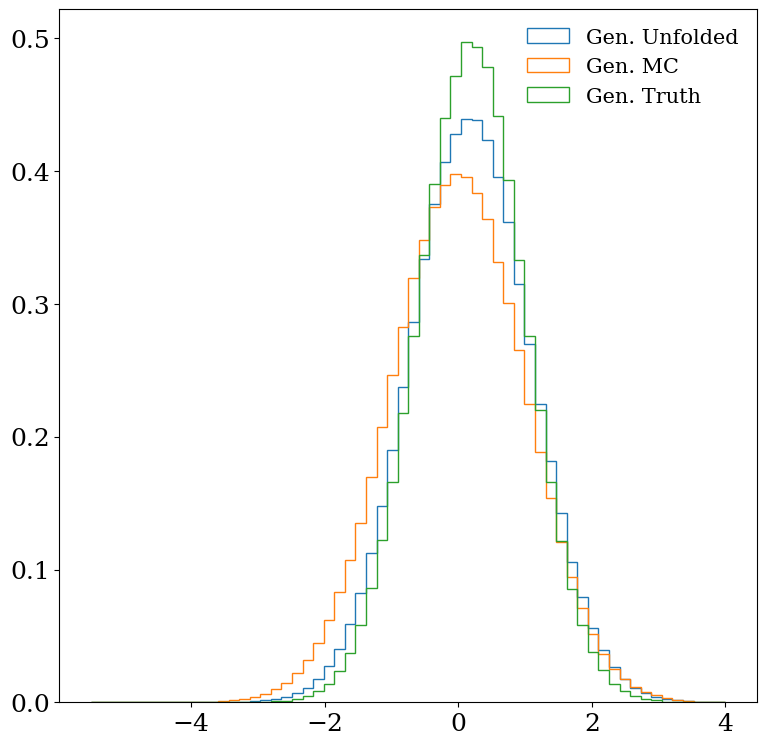

Running iteration 1
using conditional model
2025-05-28 12:26:16,306 INFO Training CFM for 100 epochs with lr 1e-05
2025-05-28 12:26:32,711 INFO Epoch 1: train_loss=0.7883, test_loss=0.7840
2025-05-28 12:26:49,100 INFO Epoch 2: train_loss=0.7863, test_loss=0.7915
2025-05-28 12:27:05,439 INFO Epoch 3: train_loss=0.7845, test_loss=0.7907
2025-05-28 12:27:21,763 INFO Epoch 4: train_loss=0.7893, test_loss=0.7884
2025-05-28 12:27:38,150 INFO Epoch 5: train_loss=0.7891, test_loss=0.7894
2025-05-28 12:27:54,480 INFO Epoch 6: train_loss=0.7895, test_loss=0.7842
2025-05-28 12:28:10,832 INFO Epoch 7: train_loss=0.7865, test_loss=0.7891
2025-05-28 12:28:27,395 INFO Epoch 8: train_loss=0.7897, test_loss=0.7903
2025-05-28 12:28:43,763 INFO Epoch 9: train_loss=0.7878, test_loss=0.7871
2025-05-28 12:29:00,065 INFO Epoch 10: train_loss=0.7886, test_loss=0.7892
2025-05-28 12:29:16,430 INFO Epoch 11: train_loss=0.7896, test_loss=0.7882
2025-05-28 12:29:32,776 INFO Epoch 12: train_loss=0.7898, test_loss=0

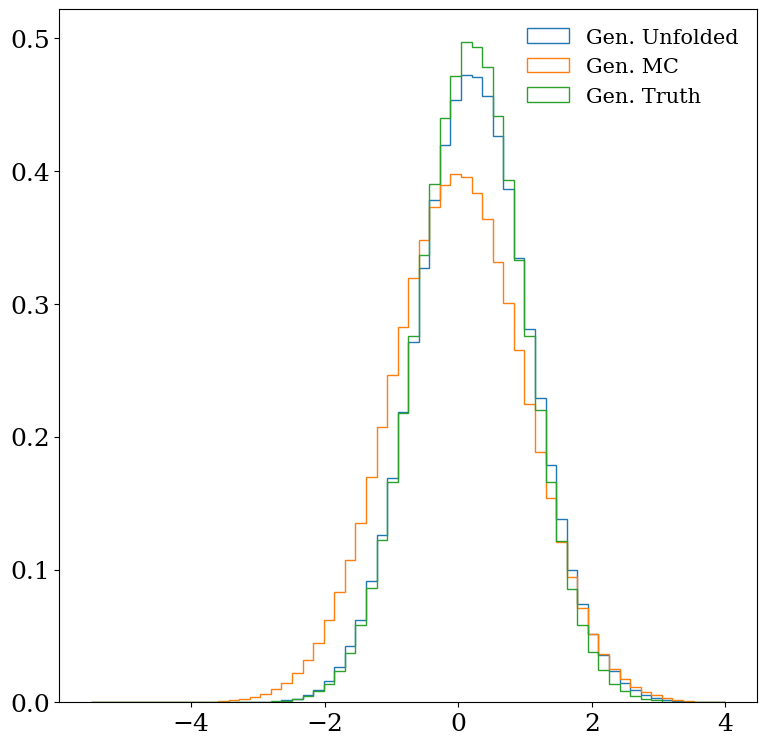

Running iteration 2
using conditional model
2025-05-28 12:58:36,905 INFO Training CFM for 100 epochs with lr 1e-05
2025-05-28 12:58:55,057 INFO Epoch 1: train_loss=0.7655, test_loss=0.7628
2025-05-28 12:59:12,881 INFO Epoch 2: train_loss=0.7664, test_loss=0.7668
2025-05-28 12:59:29,283 INFO Epoch 3: train_loss=0.7667, test_loss=0.7691
2025-05-28 12:59:45,633 INFO Epoch 4: train_loss=0.7665, test_loss=0.7669
2025-05-28 13:00:01,991 INFO Epoch 5: train_loss=0.7666, test_loss=0.7687
2025-05-28 13:00:18,356 INFO Epoch 6: train_loss=0.7648, test_loss=0.7670
2025-05-28 13:00:34,735 INFO Epoch 7: train_loss=0.7660, test_loss=0.7725
2025-05-28 13:00:53,046 INFO Epoch 8: train_loss=0.7669, test_loss=0.7679
2025-05-28 13:01:11,171 INFO Epoch 9: train_loss=0.7640, test_loss=0.7674
2025-05-28 13:01:29,169 INFO Epoch 10: train_loss=0.7670, test_loss=0.7601
2025-05-28 13:01:45,560 INFO Epoch 11: train_loss=0.7653, test_loss=0.7661
2025-05-28 13:02:03,638 INFO Epoch 12: train_loss=0.7666, test_loss=0

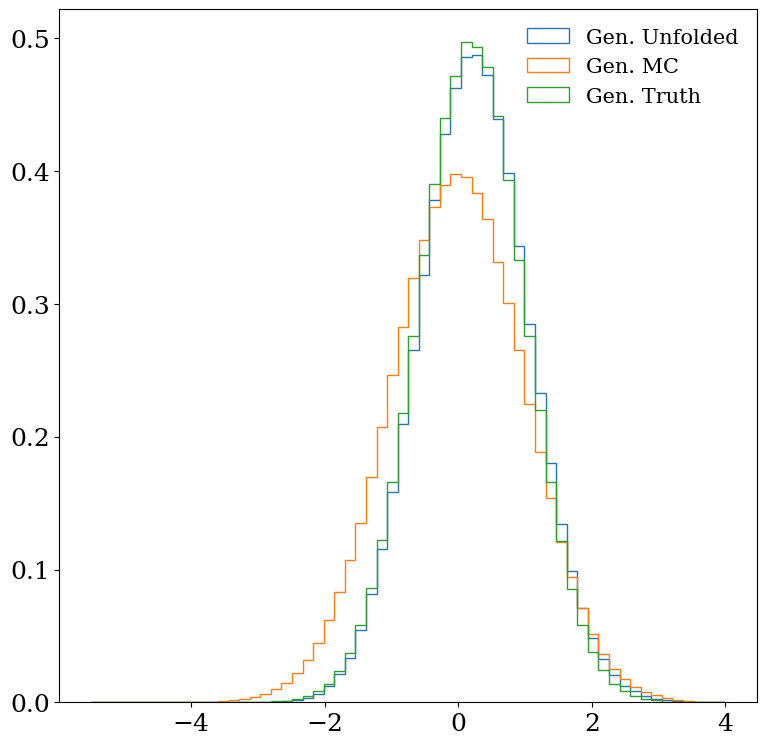

Running iteration 3
using conditional model
2025-05-28 13:27:22,332 INFO Training CFM for 100 epochs with lr 1e-05
2025-05-28 13:27:38,651 INFO Epoch 1: train_loss=0.7588, test_loss=0.7610
2025-05-28 13:27:54,986 INFO Epoch 2: train_loss=0.7603, test_loss=0.7610
2025-05-28 13:28:11,320 INFO Epoch 3: train_loss=0.7629, test_loss=0.7593
2025-05-28 13:28:27,559 INFO Epoch 4: train_loss=0.7603, test_loss=0.7631
2025-05-28 13:28:43,804 INFO Epoch 5: train_loss=0.7589, test_loss=0.7593
2025-05-28 13:29:00,057 INFO Epoch 6: train_loss=0.7606, test_loss=0.7610
2025-05-28 13:29:16,376 INFO Epoch 7: train_loss=0.7597, test_loss=0.7635
2025-05-28 13:29:32,737 INFO Epoch 8: train_loss=0.7594, test_loss=0.7634
2025-05-28 13:29:49,058 INFO Epoch 9: train_loss=0.7607, test_loss=0.7573
2025-05-28 13:30:05,369 INFO Epoch 10: train_loss=0.7582, test_loss=0.7584
2025-05-28 13:30:21,713 INFO Epoch 11: train_loss=0.7595, test_loss=0.7613
2025-05-28 13:30:38,047 INFO Epoch 12: train_loss=0.7618, test_loss=0

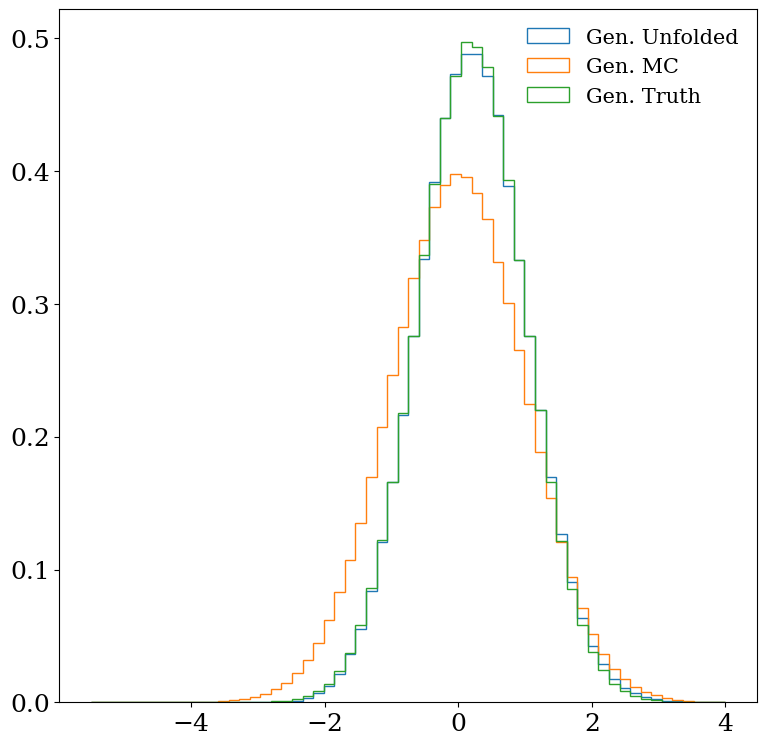

Running iteration 4
using conditional model
2025-05-28 14:00:01,918 INFO Training CFM for 100 epochs with lr 1e-05
2025-05-28 14:00:18,422 INFO Epoch 1: train_loss=0.7555, test_loss=0.7542
2025-05-28 14:00:34,861 INFO Epoch 2: train_loss=0.7540, test_loss=0.7564
2025-05-28 14:00:51,348 INFO Epoch 3: train_loss=0.7562, test_loss=0.7569
2025-05-28 14:01:07,806 INFO Epoch 4: train_loss=0.7573, test_loss=0.7555
2025-05-28 14:01:24,098 INFO Epoch 5: train_loss=0.7580, test_loss=0.7561
2025-05-28 14:01:40,625 INFO Epoch 6: train_loss=0.7547, test_loss=0.7584
2025-05-28 14:01:58,794 INFO Epoch 7: train_loss=0.7555, test_loss=0.7563
2025-05-28 14:02:16,896 INFO Epoch 8: train_loss=0.7558, test_loss=0.7551
2025-05-28 14:02:34,967 INFO Epoch 9: train_loss=0.7575, test_loss=0.7567
2025-05-28 14:02:53,065 INFO Epoch 10: train_loss=0.7570, test_loss=0.7548
2025-05-28 14:03:09,861 INFO Epoch 11: train_loss=0.7546, test_loss=0.7558
2025-05-28 14:03:27,889 INFO Epoch 12: train_loss=0.7556, test_loss=0

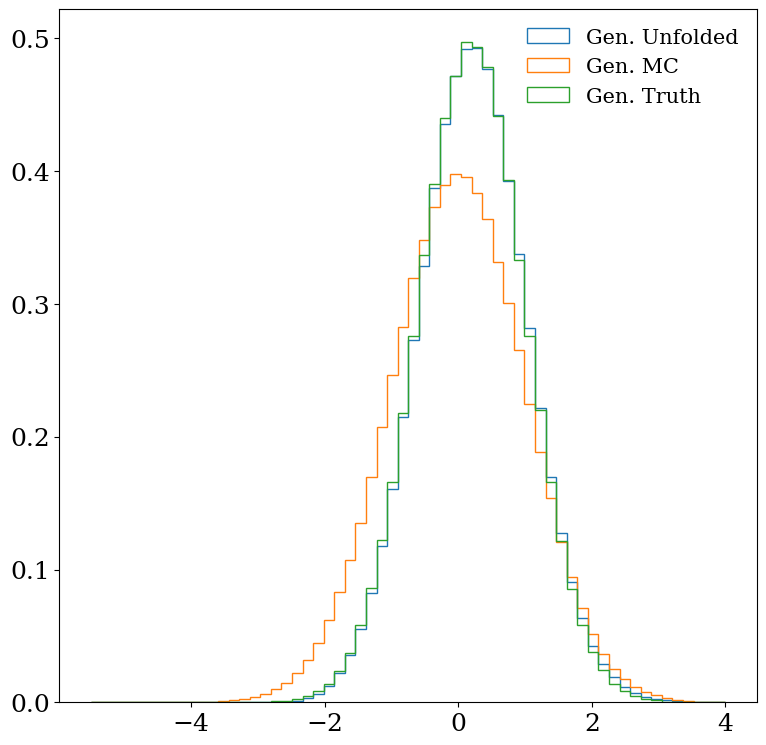

In [28]:
iterations = 5
unfold_generator =  CFM(dims_x = data_params['n_dim'], dims_c = data_params['n_dim'],params = generator_params)
for i in range(iterations):
    print(f"Running iteration {i}")
    reco_train, gen_train, gen_mask, reco_mask = sample_reco(data_params['n_mc'], 
                                                             data_params['efficiency'],
                                                             efficiency_classifier,
                                                             detector_generator,
                                                             gen_generator)
    unfold_generator.train(gen_train[gen_mask.bool()], 
                           weights = torch.ones_like(gen_train[gen_mask.bool()][:,0]), 
                           data_c = reco_train[gen_mask.bool()])
    
    #Update the acceptance model
    acceptance_classifier.train_classifier(
                reco_train[(reco_mask.bool()) & (gen_mask.bool())],
                reco_train[(reco_mask.bool()) & ~(gen_mask.bool())], balanced=False
            )
    acceptance = torch.cat([acceptance_classifier.evaluate(generated_signal[signal_mask.bool()], return_weights=False),
                            torch.ones_like(generated_signal[~signal_mask.bool()][:,0])],-1)    
    acceptance_mask = torch.bernoulli(acceptance)
    
    #Generate unfolded events
    unfolded = unfold_generator.evaluate(data_c=generated_signal)
    
    #Train generator model after applying the acceptance model
    gen_generator.train(unfolded[acceptance_mask.bool()], weights=torch.ones_like(unfolded[:, 0][acceptance_mask.bool()]))

    fig, axes = plt.subplots()
    axes.hist(unfolded[:,0].cpu().detach().numpy(), bins=60, histtype="step", range=[-5.5,4],label="Gen. Unfolded",density=True)
    axes.hist(ToyModel.mc_gen[:,0][ToyModel.mc_gen_mask.bool()].cpu().detach().numpy(),bins=60, histtype='step', range=[-5.5,4],label="Gen. MC",density=True)
    axes.hist(ToyModel.data_gen[:,0][ToyModel.data_gen_mask.bool()].cpu().detach().numpy(), 
              bins=60, range=[-5.5,4], histtype="step", label="Gen. Truth",density=True)
    plt.legend()  # Display the legend
    plt.show()

In [29]:
with PdfPages(f"Plots/final_generative_unfolding.pdf") as out:
    plot_naive_unfold(out, 
                      ToyModel.data_gen[:, 0][ToyModel.data_gen_mask.bool()].cpu().detach().numpy(),
                      ToyModel.data_rec[:, 0][ToyModel.data_rec_mask.bool()].cpu().detach().numpy(),
                      unfolded[:, 0].cpu().detach().numpy(),
                      range=[-3, 4], name="x_1")

/global/u2/v/vmikuni/Full_Generative_Unfolding/plots.py:96: RuntimeWarning: invalid value encountered in divide
  ratio = (y * scale) / (hists[0] * scales[0])
/global/u2/v/vmikuni/Full_Generative_Unfolding/plots.py:97: RuntimeWarning: invalid value encountered in divide
  ratio_err = np.sqrt((y_err / y) ** 2 + (hist_errors[0] / hists[0]) ** 2)
/global/u2/v/vmikuni/Full_Generative_Unfolding/plots.py:96: RuntimeWarning: divide by zero encountered in divide
  ratio = (y * scale) / (hists[0] * scales[0])
